In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor,LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor
import geopandas as gpd

In [2]:
zips=gpd.read_file('ZIP_CODE_040114.shp')
zips.head()

,geometry
0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [3]:
data = pd.read_csv('Features_Zipcode_Final.csv')

In [4]:
data['Area'] = zips.area*1e7

In [5]:
data.head()

,ZIPCODE,TOTAL STREET LENGTH,TOTAL BIKE LANE LENGTH,BIKE LANE DENSITY,NUM_DOCKS_AVAILABLE,TRIPS,NORMALIZED ACCIDENT COUNT,WHITE_POP %,POPULATION,ACCIDENT COUNT,MEAN INCOME,Area
0,11436,NaN,NaN,NaN,NaN,8192.653036,0.378388,7.031032,17949.0,31.0,29271.0,2.269930e+14
1,11213,146367.805288,28632.146155,0.195618,NaN,780.000000,45.128205,28.880142,63767.0,352.0,29216.0,2.963100e+14
2,11212,215912.786687,40575.901547,0.187927,NaN,87326.231788,0.381329,11.172781,84500.0,333.0,20958.0,4.197210e+14
3,11225,114141.251961,26079.822125,0.228487,149.0,6879.000000,4.564617,31.436415,56829.0,314.0,38992.0,2.369863e+14
4,11218,208355.389994,24186.845000,0.116085,23.0,1186.000000,28.667791,62.269343,75220.0,340.0,36189.0,3.686880e+14


In [6]:
data['POPULATION'] = data['POPULATION']/data['Area']

In [7]:
data.shape

(248, 12)

In [8]:
data1 = data[['ZIPCODE','BIKE LANE DENSITY','WHITE_POP %','MEAN INCOME','POPULATION']].dropna().set_index('ZIPCODE',drop=True)
data1.columns = data1.columns.str.replace(' ', '_')
data1.shape

(172, 4)

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 11213 to 10310
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BIKE_LANE_DENSITY  172 non-null    float64
 1   WHITE_POP_%        172 non-null    float64
 2   MEAN_INCOME        172 non-null    float64
 3   POPULATION         172 non-null    float64
dtypes: float64(4)
memory usage: 6.7 KB


In [10]:
data.shape

(248, 12)

In [11]:
data1.head()

,BIKE_LANE_DENSITY,WHITE_POP_%,MEAN_INCOME,POPULATION
ZIPCODE,,,,
11213,0.195618,28.880142,29216.0,2.152036e-10
11212,0.187927,11.172781,20958.0,2.013242e-10
11225,0.228487,31.436415,38992.0,2.397987e-10
11218,0.116085,62.269343,36189.0,2.040207e-10
11226,0.136211,16.696531,31064.0,2.577407e-10


In [12]:
data1.shape

(172, 4)

In [13]:
data1=data1[(data1["MEAN_INCOME"] < data1["MEAN_INCOME"].quantile(.95)) & (data1["MEAN_INCOME"] > data1["MEAN_INCOME"].quantile(.05))]
data1=data1[(data1["POPULATION"] < data1["POPULATION"].quantile(.95)) & (data1["POPULATION"] > data1["POPULATION"].quantile(.05))]

data1.shape

(138, 4)

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

cols=data1.columns
data1[cols]=scaler.fit_transform(data1[cols])

In [15]:
data1.head()

,BIKE_LANE_DENSITY,WHITE_POP_%,MEAN_INCOME,POPULATION
ZIPCODE,,,,
11213,0.361635,0.243643,0.104958,0.029689
11212,0.347400,0.074801,0.031679,0.027584
11225,0.422476,0.268017,0.191707,0.033420
11218,0.214420,0.562014,0.166834,0.027993
11226,0.251674,0.127471,0.121356,0.036141


In [16]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 11213 to 10075
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BIKE_LANE_DENSITY  138 non-null    float64
 1   WHITE_POP_%        138 non-null    float64
 2   MEAN_INCOME        138 non-null    float64
 3   POPULATION         138 non-null    float64
dtypes: float64(4)
memory usage: 5.4 KB


<AxesSubplot:>

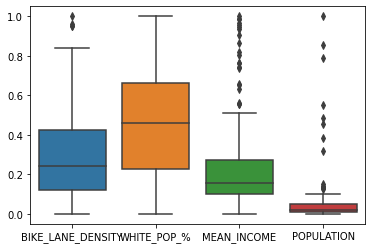

In [17]:
sns.boxplot(data=data1)

In [18]:
data1 = data1.rename({"WHITE_POP_%":"WHITE_POP_PERC",},axis=1)

In [19]:
base=10
data1['Log_WHITE_POP_PERC'] = np.log(np.array(data1['WHITE_POP_PERC'])+1e-9)/np.log(base)
data1['Log_MEAN_INCOME'] = np.log(np.array(data1['MEAN_INCOME'])+1e-9)/np.log(base)
data1['Log_POPULATION'] = np.log(np.array(data1['POPULATION'])+1e-9)/np.log(base)
data1['Log_BIKE_LANE_DENSITY'] = np.log(np.array(data1['BIKE_LANE_DENSITY'])+1e-9)/np.log(base)

root=1/4
data1['root_WHITE_POP_PERC'] = np.power(np.array(data1['WHITE_POP_PERC']),root)
data1['root_MEAN_INCOME'] = np.power(np.array(data1['MEAN_INCOME']),root)
data1['root_POPULATION'] = np.power(np.array(data1['POPULATION']),root)
data1['root_BIKE_LANE_DENSITY'] = np.power(np.array(data1['BIKE_LANE_DENSITY']),root)

In [20]:
lm1 = smf.ols(formula='BIKE_LANE_DENSITY ~ root_POPULATION-1',data=data1).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      BIKE_LANE_DENSITY   R-squared (uncentered):                   0.547
Model:                            OLS   Adj. R-squared (uncentered):              0.544
Method:                 Least Squares   F-statistic:                              165.5
Date:                Tue, 13 Dec 2022   Prob (F-statistic):                    2.48e-25
Time:                        18:47:32   Log-Likelihood:                         -7.5749
No. Observations:                 138   AIC:                                      17.15
Df Residuals:                     137   BIC:                                      20.08
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
root_POPULATION     0.6459      0.050     12.866      0.000       0.547       0.745
==============================================================================
Omnibus:                       11.674   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.631
Skew:                           0.605   Prob(JB):                      0.00181
Kurtosis:                       3.856   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
from IPython.display import Markdown as md
md("$$ BikeLaneDensity = ({}*root(POPULATION))^{}$$".format(lm1.params[0],root))

$$ BikeLaneDensity = (0.6458937489881512*root(POPULATION))^0.25$$

In [22]:
lm2 = smf.ols(formula='BIKE_LANE_DENSITY ~ MEAN_INCOME-1',data=data1).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      BIKE_LANE_DENSITY   R-squared (uncentered):                   0.607
Model:                            OLS   Adj. R-squared (uncentered):              0.604
Method:                 Least Squares   F-statistic:                              211.9
Date:                Tue, 13 Dec 2022   Prob (F-statistic):                    1.35e-29
Time:                        18:47:32   Log-Likelihood:                          2.2671
No. Observations:                 138   AIC:                                     -2.534
Df Residuals:                     137   BIC:                                     0.3931
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
MEAN_INCOME     0.8197      0.056     14.557      0.000       0.708       0.931
==============================================================================
Omnibus:                       10.186   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               15.552
Skew:                           0.365   Prob(JB):                     0.000420
Kurtosis:                       4.473   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
from IPython.display import Markdown as md
md("$$ BikeLaneDensity = ({}*MEAN INCOME)$$".format(lm2.params[0]))

$$ BikeLaneDensity = (0.8197070819628614*MEAN INCOME)$$

In [24]:
lm3 = smf.ols(formula='BIKE_LANE_DENSITY ~ WHITE_POP_PERC-1',data=data1).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      BIKE_LANE_DENSITY   R-squared (uncentered):                   0.598
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              203.8
Date:                Tue, 13 Dec 2022   Prob (F-statistic):                    6.80e-29
Time:                        18:47:32   Log-Likelihood:                         0.64411
No. Observations:                 138   AIC:                                     0.7118
Df Residuals:                     137   BIC:                                      3.639
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
WHITE_POP_PERC     0.5774      0.040     14.276      0.000       0.497       0.657
==============================================================================
Omnibus:                        3.753   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                3.213
Skew:                           0.319   Prob(JB):                        0.201
Kurtosis:                       3.389   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
md("$$ BikeLaneDensity = ({}*WHITE POP PERCENTAGE)$$".format(lm3.params[0]))

$$ BikeLaneDensity = (0.5774334395058394*WHITE POP PERCENTAGE)$$

In [26]:
lm4 = smf.ols(formula='BIKE_LANE_DENSITY ~ MEAN_INCOME+root_POPULATION+WHITE_POP_PERC-1',data=data1).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      BIKE_LANE_DENSITY   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.698
Method:                 Least Squares   F-statistic:                              107.4
Date:                Tue, 13 Dec 2022   Prob (F-statistic):                    1.38e-35
Time:                        18:47:32   Log-Likelihood:                          21.925
No. Observations:                 138   AIC:                                     -37.85
Df Residuals:                     135   BIC:                                     -29.07
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
MEAN_INCOME         0.4777      0.088      5.456      0.000       0.305       0.651
root_POPULATION     0.3067      0.068      4.529      0.000       0.173       0.441
WHITE_POP_PERC      0.0879      0.078      1.121      0.264      -0.067       0.243
==============================================================================
Omnibus:                       21.094   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.978
Skew:                           0.833   Prob(JB):                     5.10e-07
Kurtosis:                       4.504   Cond. No.                         4.39
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
lm4.params

MEAN_INCOME        0.477667
root_POPULATION    0.306663
WHITE_POP_PERC     0.087864
dtype: float64

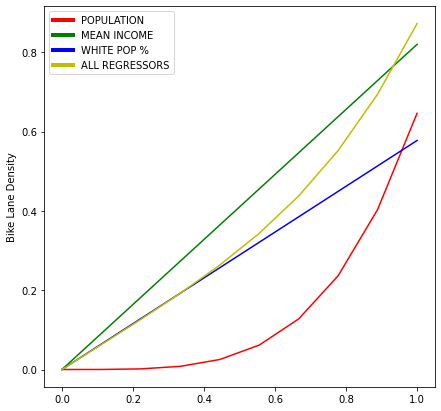

In [28]:
x_mesh = np.linspace(0,1,10)
y_mesh_1 = np.power(x_mesh,4)*lm1.params[0]
y_mesh_2 = np.power(x_mesh,1)*lm2.params[0]
y_mesh_3 = np.power(x_mesh,1)*lm3.params[0]
y_mesh_4 = np.power(x_mesh,1)*lm4.params[0] + np.power(x_mesh,4)*lm4.params[1] + np.power(x_mesh,1)*lm4.params[2]

plt.rcParams["figure.figsize"] = (7,7)
plt.plot(x_mesh,y_mesh_1,'-r')
plt.plot(x_mesh,y_mesh_2,'-g')
plt.plot(x_mesh,y_mesh_3,'-b')
plt.plot(x_mesh,y_mesh_4,'-y')
plt.ylabel('Bike Lane Density')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='y', lw=4)]

plt.legend(custom_lines, ['POPULATION', 'MEAN INCOME', 'WHITE POP %','ALL REGRESSORS'])